Per el nostre projecte hem considerat dues distribucions de posicions: per una banda una distribució de cinc posicions diferents considerant el repós, que inclou presa cilíndrica, presa ganxo, presa trípode i pinça lateral, per l'altre hi ha dues posicions considerant repós i presa trípode.

Per estudiar la diferenciació de les posicions, utilitzarem el dataset public 'Ninapro' (podeu veure una breu visualització i explicació del ds en el fitxer 'provesEMG_Ninapro_df\s1\dataset_visualization.ipynb'), buscarem cinc posicions com les descrites i a partir d'elles haurem de buscar un canal d'electròdes que ens permeti diferenciarles i interpretar quines són les features diferencials per poder entrenar posteriorment models de ML efectivament, en un altre estudi comapararem l'efectivitat dels models implementats amb models de DL.


In [12]:
# Imports
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

### Tasca 1: Escollir posicions del dataset corresponents a les posicions buscades

#### Excercise 2: isometric, isotonic hand configurations and basic wrist movements.

D'aquest excercici únicament farem servir la posició *Fingers flexed together in fist*, corresponent a la posició més similar que hem trobat de la *presa ganxo*.

In [2]:
data_e2 = loadmat("S1_A1_E2.mat")

#### Excercise 3: Grasping and functional movements.

D'aquest excercici farem servir: *Large diameter grasp*, corresponent a *presa cilíndrica*, *Writing tripod grasp*, corresponent a *presa trípode*, *Lateral grasp*, corresponent a *pinça lateral* 

Aquest dataset és un estudi de fisiologia, llavors no considera la posició de *repós* com una posició sinó com un estat inicial.

In [ ]:
data_e3 = loadmat("S1_A1_E3.mat")


In [5]:
for k, v in data_e3.items():
    if k.startswith("__"): 
        continue
    shape = getattr(v, "shape", None)
    print(f"{k:12s} type={type(v).__name__:10s} shape={shape}")

emg          type=ndarray    shape=(227493, 10)
stimulus     type=ndarray    shape=(227493, 1)
glove        type=ndarray    shape=(227493, 22)
subject      type=ndarray    shape=(1, 1)
exercise     type=ndarray    shape=(1, 1)
repetition   type=ndarray    shape=(227493, 1)
restimulus   type=ndarray    shape=(227493, 1)
rerepetition type=ndarray    shape=(227493, 1)


In [ ]:
emg = data_e3["emg"]
restim = data_e3["restimulus"].ravel()
rerep  = data_e3["rerepetition"].ravel()
# utilitzo restimulus i rerepetition en comptes de stimulus i repetition, ja que són dades més netes

In [11]:
print("Gestos:", np.unique(restim))
print("Repeticions:", np.unique(rerep))

Gestos: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Repeticions: [ 0  1  2  3  4  5  6  7  8  9 10]


In [38]:
idx1 = np.where(restim == 1)[0]
if len(idx1) == 0:
    raise ValueError("No hi ha cap mostra amb restimulus==1 en aquest fitxer.")

start, end = int(idx1[0]), int(idx1[-1])  # inclou tot el que hi ha entremig
X = emg[start:end+1, :]                   # (T, 10)
y = restim[start:end+1]                   # (T,)

print("Tram seleccionat:", start, "->", end, "mostres:", X.shape[0])

Tram seleccionat: 391 -> 8304 mostres: 7914


In [39]:
# Opcional: subsample per fer els plots més ràpids si és molt llarg
step = 1   # posa 5, 10, 20 si va lent
X = X[::step, :]
y = y[::step]
t = np.arange(X.shape[0])

# Mascara on el gest és 1 (per ombrejar)
mask1 = (y == 1)

In [ ]:
# Funció per ombrejar zones on mask és True
def shade_mask(ax, mask, ymin, ymax, alpha=0.15):
    ax.fill_between(t, ymin, ymax, where=mask, alpha=alpha, step="pre")

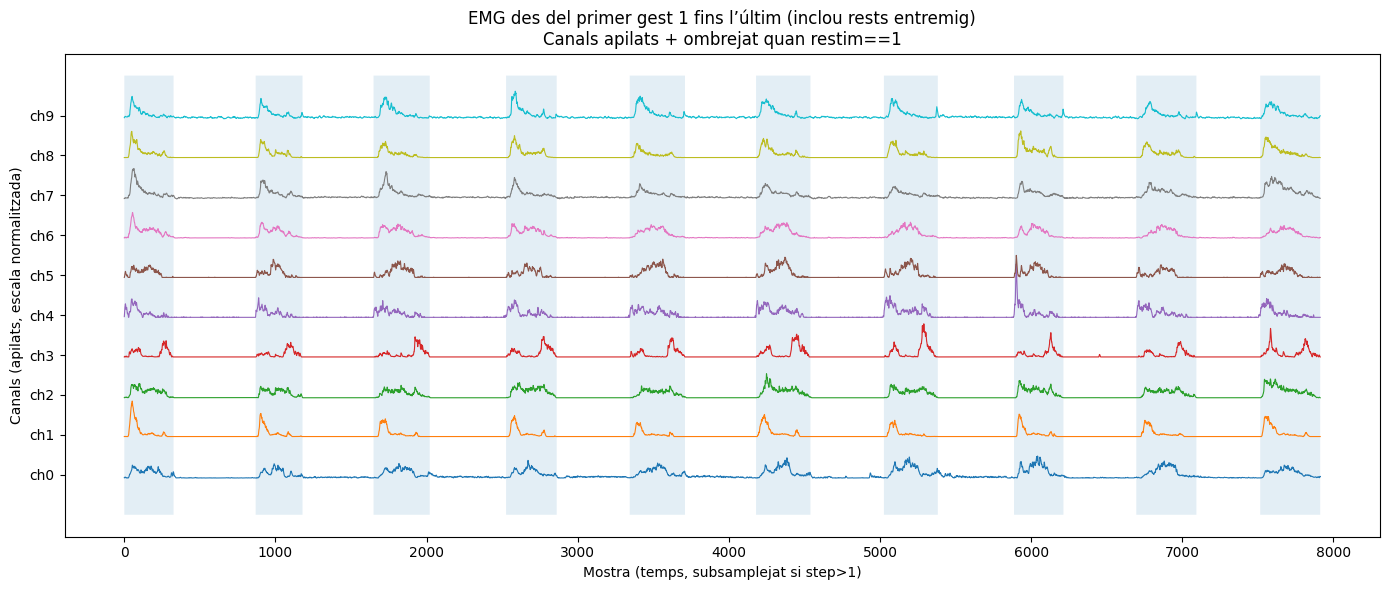

In [ ]:
# Normalitza per canal només per visualització, si es vol vere sense normalitzar utilitzar X en comptes de XN
mu = X.mean(axis=0, keepdims=True)
sd = X.std(axis=0, keepdims=True) + 1e-9
XN = (X - mu) / sd

plt.figure(figsize=(14, 6))

offset = 10.0  # separació vertical
for ch in range(XN.shape[1]):
    plt.plot(t, XN[:, ch] + ch * offset, linewidth=0.8)

# Ombreja zones on restim==1
ymin = -offset
ymax = (XN.shape[1]-1) * offset + offset
plt.fill_between(t, ymin, ymax, where=mask1, alpha=0.12, step="pre")

plt.title("EMG des del primer gest 1 fins l’últim (inclou rests entremig)\nCanals apilats + ombrejat quan restim==1")
plt.xlabel("Mostra (temps, subsamplejat si step>1)")
plt.ylabel("Canals (apilats, escala normalitzada)")
plt.yticks([ch * offset for ch in range(10)], [f"ch{ch}" for ch in range(10)])
plt.tight_layout()
plt.show()

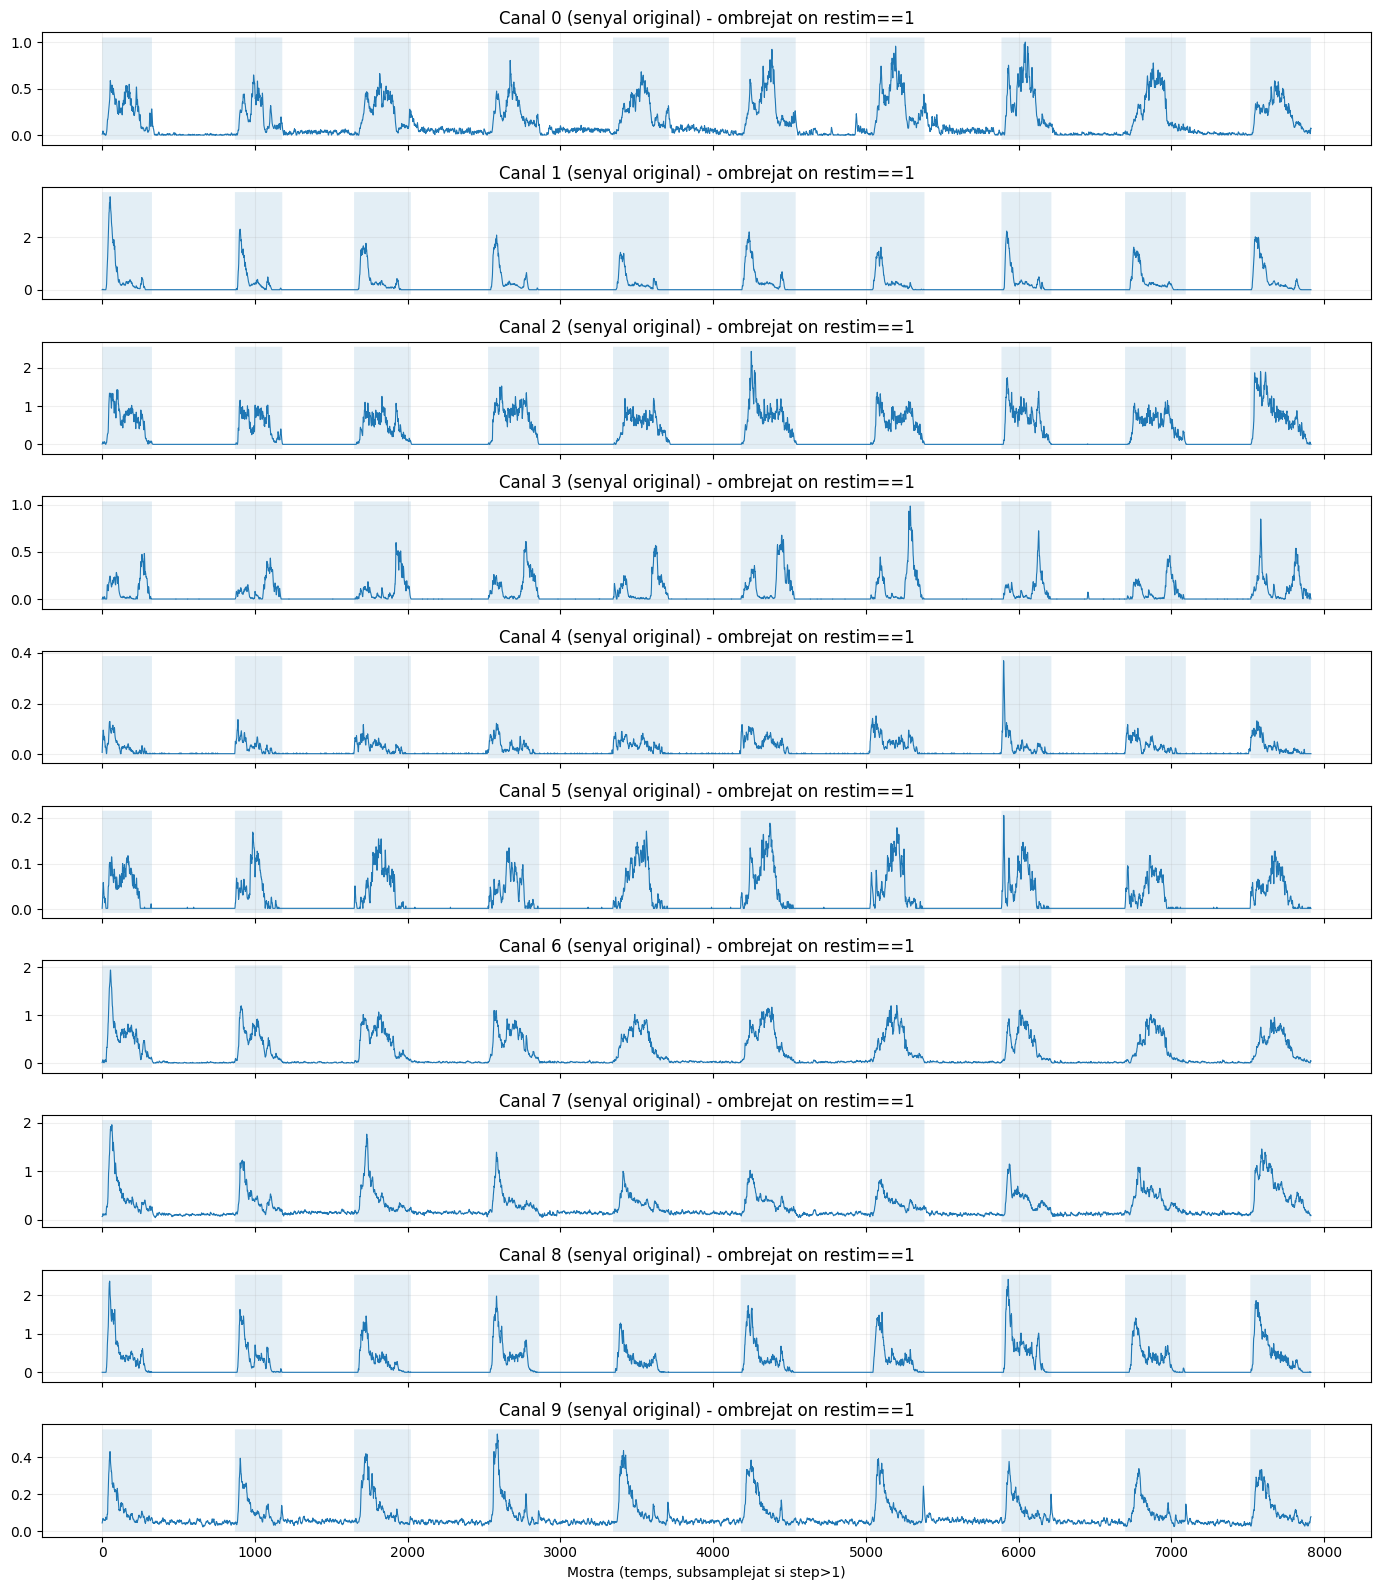

In [47]:
fig, axes = plt.subplots(10, 1, figsize=(14, 16), sharex=True)

for ch, ax in enumerate(axes):
    ax.plot(t, X[:, ch], linewidth=0.8)  # aquí mostro el senyal ORIGINAL (no normalitzat)
    ymin, ymax = ax.get_ylim()
    ax.fill_between(t, ymin, ymax, where=mask1, alpha=0.12, step="pre")
    ax.set_title(f"Canal {ch} (senyal original) - ombrejat on restim==1")
    ax.grid(True, alpha=0.2)

axes[-1].set_xlabel("Mostra (temps, subsamplejat si step>1)")
plt.tight_layout()
plt.show()


- Es veu clarament quan està en rest i quan esta realitzant un moviment.
- Almenys en aquest moviment tots els canals s'activen, però ho fan de formes diferents. Alguns s'activen més que altres i tenen patrons diferents.